# Installing and importing modules

In [1]:
! pip install spacy -U
! python -m spacy download pl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.
2023-11-21 15:39:10.749922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 15:39:10.749977: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: A

In [2]:
!python3 -m pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 877.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199774 sha256=c3eff76da1d6dd1902777448ce3a2459b90ed72818e0f3f415fbcd3a2aef149a
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [3]:
!pip install transformers

In [4]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 18.8 MB/s eta 0:00:00


In [5]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# TF-IDF
import spacy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# fastText
import fasttext
# BERT
import torch
import torch.nn as nn
import shutil
import sys
from transformers import HerbertTokenizerFast, BertModel
# analysis
import itertools
from sklearn.metrics import cohen_kappa_score
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Data preparation

In [62]:
# getting data from Google Drive
# original AR dataset: https://github.com/allegro/klejbenchmark-allegroreviews

drive.mount('/content/gdrive')
PATH = "/content/gdrive/MyDrive/SD_projekt/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
# loading data
# NOTE: dev data will be used for testing (since they have labels)

train = pd.read_csv(PATH + "AR/train.tsv", sep='\t', header=0)
test = pd.read_csv(PATH + "AR/dev.tsv", sep='\t', header=0)

In [15]:
# splitting training data into train + eval

train_size = 0.9
train = train.sample(frac=train_size, random_state=200).reset_index(drop=True)
eval = train.sample(frac=1-train_size, random_state=200).reset_index(drop=True)

In [16]:
def clean_data(data):
  data = data[data['text'].str.contains('[a-zA-z]')] # delete entries w/ empty 'text' fields
  data.drop_duplicates(inplace=True)
  return data

before = [i.shape for i in [train, eval, test]]
train = clean_data(train)
eval = clean_data(eval)
test = clean_data(test)
after = [i.shape for i in [train, eval, test]]

table = pd.DataFrame(data={'dataset': ['train', 'eval', 'test'],
                             'before': before,
                             'after': after}).set_index('dataset')
table

,before,after
dataset,,
train,"(8619, 2)","(8115, 2)"
eval,"(862, 2)","(820, 2)"
test,"(1002, 2)","(974, 2)"


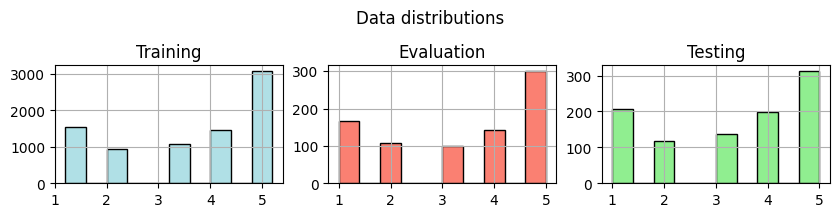

In [22]:
# data visualization

fig, axes = plt.subplots(1, 3)

train['rating'].hist(ax=axes[0], figsize = (10,2), align='right', color='powderblue', edgecolor='black')
axes[0].set_title("Training")
eval['rating'].hist(ax=axes[1], figsize = (10,2), color='salmon', edgecolor='black')
axes[1].set_title("Evaluation")
test['rating'].hist(ax=axes[2], figsize = (10,2), color='lightgreen', edgecolor='black')
axes[2].set_title("Testing")

fig.suptitle('Data distributions')
fig.subplots_adjust(top=0.7)
plt.show()

In [23]:
def calc_accuracy(lst1, lst2):
  """simple function to calculate accuracy given two lists"""
  a = np.array(lst1) # true labels
  b = np.array(lst2) # predicted labels
  correct = (a == b)
  return correct.sum() / correct.size

# TF-IDF

In [25]:
# extracting text and labels (no eval data here)

train_raw = train['text']
train_labels = train['rating']
test_raw = test['text']
test_labels = test['rating']

In [28]:
print(test_raw.head())
print(test_labels.head())

0    Generalnie ok.  Znośna jakość dźwięku. Ale to ...
1    W upalne dni przyssawka staje się tak elastycz...
2    Według mnie statyw na początku był bardzo fajn...
3    Specyfikacja mówi sama za siebie i faktycznie ...
4    Wykonanie przeciętne . Krajalnicy nie używamy ...
Name: text, dtype: object
0    3.0
1    4.0
2    1.0
3    5.0
4    3.0
Name: rating, dtype: float64


In [29]:
# creating a tokenizer

nlp = spacy.load("pl_core_news_sm")
def spacy_tokeniser(sentence):
  return [token.text for token in nlp.tokenizer(sentence)]

In [30]:
# fitting the vectorizer to data
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, min_df=2, analyzer='word', tokenizer=spacy_tokeniser, norm=None)
train_tfidf = tfidf_vectorizer.fit_transform(train_raw)
test_tfidf = tfidf_vectorizer.transform(test_raw)

# checking the number of TF-IDF features
print(train_tfidf.toarray().shape)
print(test_tfidf.toarray().shape)

(8115, 23711)
(974, 23711)


In [32]:
# putting vectorized text into KNN
knn_tfidf = KNeighborsClassifier(n_neighbors=8, algorithm='brute', metric='cosine') #'brute' i 'cosine' dają najlepsze accuracy
knn_tfidf.fit(train_tfidf, train_labels)
# making predictions
pred_test = knn_tfidf.predict(test_tfidf)
# saving the results
test_result = test.assign(pred1=pred_test.tolist())

In [34]:
print(calc_accuracy(test_labels.tolist(), pred_test.tolist()))

0.4024640657084189


# fastText

In [36]:
def prepare_data(labels, text, data):
    data_list = []
    # format data into: _label_[label] [text]
    for a in zip(labels, text):
        data_list.append(["__label__" + str(a[0])] + spacy_tokeniser(a[1]))
    # mixing examples randomly
    np_list = np.array(data_list, dtype=list)
    np.random.shuffle(np_list)
    # saving data to a new file
    for i, l in enumerate(np_list):
        data.write(" ".join(l)+'\n')

In [37]:
# adding raw eval data
eval_raw = eval['text']
eval_labels = eval['rating']

In [38]:
# training data
train_data = open("train_data.txt", "w")
prepare_data(train_labels, train_raw, train_data)

# evaluation data
eval_data = open("eval_data.txt", "w")
prepare_data(eval_labels, eval_raw, eval_data)

# testing data
test_data = open("test_data.txt", "w")
prepare_data(test_labels, test_raw, test_data)

In [42]:
!head train_data.txt

__label__5.0 Wtyk F Cabelcon samokompresyjny   Tak trwałe jak złącze zaciskane . . . ale zakładasz bez zaciskarki !   Rewelacyjny wtyk F duńskiej firmy Cabelcon dedykowany jest do domowych oraz zbiorczych instalacji antenowych . Opatentowana konstrukcja , bazująca na technice " Self - Install " , zapewnia profesjonalne oraz przede wszystkim trwałe połączenie - porównywalne z tymi , oferowanymi przez złącza kompresyjne .   Do montażu wtyku , nie wymagane jest żadne narzędzie , ponieważ proces zaciskania na przewodzie zachodzi tutaj samoczynnie .    Najlepiej pasuje do kabli koncentrycznych Triset - 113 lub innych o średnicy zewnętrznej 6,8   mm . Dane techniczne złącza samokompresyjnego F Cabelcon :       Model : F - 56 5 . 1      Impedancja : 75       Ekranowanie dla częst . 30 - 862 MHz : 110dB      Średnica wewnętrzna : 7,2 mm      Średnica zewnętrzna ( nakrętki ): 12,5 mm      Średnica wewnętrzna dla dielektryka przewodu : 5,1 mm
__label__4.0 delikatnie się zawiodłam na tym pokrowcu

In [43]:
# train a classifier (w/ best hyperparameters for this example)
ft_classifier = fasttext.train_supervised(input="train_data.txt",
                                          autotuneValidationFile='eval_data.txt',
                                          epoch=40, lr=0.05)

In [46]:
def get_predictions(data):
  """save prediction for each review from a file to a list of floats"""
  predictions = []
  for review in data['text']:
    res = ft_classifier.predict(review)[0]
    predictions.append(float(res[0][-3:])) # last 3 characters - so the rating (e.g. 2.0)
  return predictions

p_test = get_predictions(test)
test_result['pred2'] = p_test # save predictions
print(calc_accuracy(test_labels.tolist(), p_test))

0.5349075975359343


In [48]:
ft_classifier.test('test_data.txt') # precision, recall

(971, 0.5581874356333677, 0.5581874356333677)

In [53]:
# two cases where the models works well
print(ft_classifier.predict("Zostałam oszukana, jak mogą takie coś w ogóle ludziom sprzedawać")[0])
print(ft_classifier.predict("Nigdy nie miałam lepszych okularów niż te")[0])
# and one where it doesn't
print(ft_classifier.predict("Bardzo żałuję tego zakupu")[0])

('__label__1.0',)
('__label__5.0',)
('__label__5.0',)


# BERT

In [63]:
# BERT training procedure taken from: https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi%20Label%20Text%20Classification%20using%20BERT%20PyTorch/bert_multilabel_pytorch_standard.ipynb

# original training data loaded and cleaned once again! (they will be split later)
train = clean_data(pd.read_csv(PATH + "AR/train.tsv", sep='\t', header=0))

def transform_data(data):
  """one-hot encoding for the labels"""
  labels = sorted(data['rating'].value_counts().index.tolist())
  for label in labels:
    data[str(label)] = 0
    for ind in data.index:
      if int(data['rating'][ind]) == label:
        data[str(label)][ind] = 1
  data.drop(labels=['rating'], axis=1, inplace=True)
  return data

transform_data(train)
print((train.sample(5)))

                                                   text  1.0  2.0  3.0  4.0  \
762   Zakupiłam produkt ze względu na możliwość kont...    0    0    0    1   
8449  Oceniam na 5 bo już nie raz pewnie było by już...    0    0    0    0   
5752  Przy core i5 3470 (TDP 77W) na standardowych z...    0    0    0    0   
3733  Uchwyt nie jest stabilny. Część przykręcana do...    0    1    0    0   
3919  Jakość dźwięku za tą cenę doskonała, wygląd i ...    0    0    1    0   

      5.0  
762     0  
8449    1  
5752    1  
3733    0  
3919    0  


In [64]:
# labels list
target_list = ['1.0', '2.0', '3.0', '4.0', '5.0']

# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [65]:
tokenizer = HerbertTokenizerFast.from_pretrained("allegro/herbert-base-cased")

tokenizer_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/907k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/556k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [66]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [67]:
# splitting the training data again
train_size = 0.9
train_df = train.sample(frac=train_size, random_state=200).reset_index(drop=True)
eval_df = train.sample(frac=1-train_size, random_state=200).reset_index(drop=True)

train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(eval_df, tokenizer, MAX_LEN)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)
eval_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [68]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [69]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [70]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained("allegro/herbert-base-cased", return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [71]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

val_targets=[]
val_outputs=[]

In [72]:
def train_model(n_epochs, training_loader, validation_loader, model,
                optimizer, checkpoint_path, best_model_path):

  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf


  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)

    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################
    # validate the model #
    ######################

    model.eval()

    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }

        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)

      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [73]:
ckpt_path = PATH + "/model/curr_ckpt"
best_model_path = PATH + "model/best_model.pt"

In [74]:
# training again
#trained_model = train_model(EPOCHS, train_data_loader, eval_data_loader, model, optimizer, ckpt_path, best_model_path)
# loading the trained model
trained_model = torch.load(best_model_path)

In [75]:
def testing(data, i):
    example = data['text'][i]
    encodings = tokenizer.encode_plus(
      example,
      None,
      add_special_tokens=True,
      max_length=MAX_LEN,
      padding='max_length',
      return_token_type_ids=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt'
    )
    model.eval()
    with torch.no_grad():
      input_ids = encodings['input_ids'].to(device, dtype=torch.long)
      attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
      token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
      output = model(input_ids, attention_mask, token_type_ids)
      final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
      res = train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))]
    return res

In [78]:
# running the test dataset must be done in parts (or errors are thrown)!
#results = [testing(test,i) for i in range(0, len(test))]
#test_result['pred3'] = results # saving the results

# Results and analysis

In [79]:
results = pd.read_csv(PATH + "/result.csv", header=0)
results.head()

,Unnamed: 0,text,rating,pred1,pred2,pred3
0,0,Generalnie ok. Znośna jakość dźwięku. Ale to ...,3.0,5.0,3.0,4.0
1,1,W upalne dni przyssawka staje się tak elastycz...,4.0,5.0,4.0,4.0
2,2,Według mnie statyw na początku był bardzo fajn...,1.0,5.0,3.0,1.0
3,3,Specyfikacja mówi sama za siebie i faktycznie ...,5.0,1.0,5.0,5.0
4,4,Wykonanie przeciętne . Krajalnicy nie używamy ...,3.0,1.0,1.0,2.0


In [82]:
# accuracy table
vals = []
for col in ['pred1', 'pred2', 'pred3']:
  acc = calc_accuracy(results['rating'], results[col])
  vals.append(acc)

acc_table = pd.DataFrame(data={'name': ['TF-IDF', 'fastText', 'BERT'],
                            'accuracy': vals})
acc_table

,name,accuracy
0,TF-IDF,0.402464
1,fastText,0.536961
2,BERT,0.514374


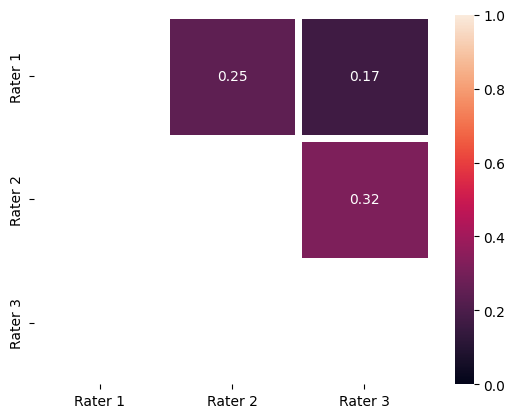

In [84]:
# Cohen's kappa coefficient for model pairs
rater1 = results['pred1']
rater2 = results['pred2']
rater3 = results['pred3']
raters = [rater1, rater2, rater3]

data = np.zeros((len(raters), len(raters)))
for j, k in list(itertools.combinations(range(len(raters)), r=2)):
    data[j, k] = cohen_kappa_score(raters[j], raters[k])

# plot
sns.heatmap(
    data,
    mask=np.tri(len(raters)),
    annot=True, linewidths=5,
    vmin=0, vmax=1,
    xticklabels=[f"Rater {k + 1}" for k in range(len(raters))],
    yticklabels=[f"Rater {k + 1}" for k in range(len(raters))],
)
plt.show()